In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd    # Pandas used to save material as csv

In [2]:
eps0 = 8.854187812813e-12  #Vacuum Electric Permittivity
mu0 = 1.2566370621219e-6  #Vacuum Magnetic Permeability
c0 = round(1/np.sqrt(mu0*eps0))   # Speed of light in a vacuum
imax = 400   # Maximum number cells in x-direction
jmax = 400   # Maximum number cells in y-direction

MatCenti = imax/2    # Centre of the material
MatCentj = jmax/2

f = 857e12  # Frequency input to determine cell width
nmax = 10 # Maximum optical density
deltax = c0/(20*f*nmax)    # Cell width
deltay = c0/(20*f*nmax)

radius = 40*deltax   # Schwarzschild radius of BH
m,n,r,L,L1 = symbols('m n r L L1')  # Define symbols for sympy

In [3]:
#Upper indices version of metric tensor outside and inside of Schwarzschild radius
gext = Matrix([[1/(1-L1/(m**2+n**2)**0.5),0,0,0],[0,m**2*L1/(m**2+n**2)**1.5-1,m*n*L1/(m**2+n**2)**1.5,0],[0,m*n*L1/(m**2+n**2)**1.5,n**2*L1/(m**2+n**2)**1.5-1,0],[0,0,0,-1]])
gint = Matrix([[1/(1-L1/(m**2+n**2)**0.5),0,0,0],[0,m**2*L1/((m**2+n**2)*L)-1,m*n*L1/((m**2+n**2)*L),0],[0,m*n*L1/((m**2+n**2)*L),n**2*L1/((m**2+n**2)*L)-1,0],[0,0,0,-1]])

In [4]:
#upper indices converted into permittivity tensor
epsext = gext*-(1-L1/(m**2+n**2)**0.5)**-1
epsint = gint*-(1-L1/(L))**-1

In [5]:
#Inverse to obtain lower indices
epslowext = epsext.inv()
epslowint = epsint.inv()

In [6]:
# Create lambda functions for permittivity tensor
# Each function evaluated at the same cell location of field it is used for (j+0.5 for Hx etc.)
i,j = symbols('i j')
extf1 = lambdify([i,j],epslowext[1,1].subs({m:(i-MatCenti)*deltax,n:(j+0.5-MatCenti)*deltax,L1:0.9*radius,L:radius}))
extf2 = lambdify([i,j],epslowext[1,2].subs({m:(i-MatCenti)*deltax,n:(j+0.5-MatCenti)*deltax,L1:0.9*radius,L:radius}))
extf3 = lambdify([i,j],epslowext[2,2].subs({m:(i-MatCenti+0.5)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))
extf4 = lambdify([i,j],epslowext[2,1].subs({m:(i-MatCenti+0.5)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))
extf5 = lambdify([i,j],epslowext[3,3].subs({m:(i-MatCenti)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))

intf1 = lambdify([i,j],epslowint[1,1].subs({m:(i-MatCenti)*deltax,n:(j+0.5-MatCenti)*deltax,L1:0.9*radius,L:radius}))
intf2 = lambdify([i,j],epslowint[1,2].subs({m:(i-MatCenti)*deltax,n:(j+0.5-MatCenti)*deltax,L1:0.9*radius,L:radius}))
intf3 = lambdify([i,j],epslowint[2,2].subs({m:(i-MatCenti+0.5)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))
intf4 = lambdify([i,j],epslowint[1,2].subs({m:(i-MatCenti+0.5)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))
intf5 = lambdify([i,j],epslowint[3,3].subs({m:(i-MatCenti)*deltax,n:(j-MatCenti)*deltax,L1:0.9*radius,L:radius}))

In [7]:
# Creating matrices that show if the device is present at a given cell
# Antidevice is 1 when device is not present
deviceHx = np.zeros((imax,jmax))
antideviceHx = np.zeros((imax,jmax))
deviceHy = np.zeros((imax,jmax))
antideviceHy = np.zeros((imax,jmax))
deviceDz = np.zeros((imax,jmax))
antideviceDz = np.zeros((imax,jmax))

for i in range(imax):
    for j in range(jmax):
        if (i-MatCenti)**2+(j-MatCentj+0.5)**2 <= (radius/(deltax))**2:  # Hx evaluated at i,j+0.5
            deviceHx[i,j] = 1
        else:
            antideviceHx[i,j] = 1
        if (i-MatCenti+0.5)**2+(j-MatCentj)**2 <= (radius/(deltax))**2: # Hy evaluated at i+0.5,j
            deviceHy[i,j] = 1
        else:
            antideviceHy[i,j] = 1
        if (i-MatCenti)**2+(j-MatCentj)**2 <= (radius/(deltax))**2:     # Dz evaluated at i,j
            deviceDz[i,j] = 1
        else:
            antideviceDz[i,j] = 1


In [17]:
# Creating material from device matrices and lambda functions
X,Y=np.meshgrid(range(imax),range(jmax))    # Arrays covering all cells in grid
            
Materialxx = np.multiply(antideviceHx,extf1(Y,X))+np.multiply(deviceHx,intf1(Y,X))  # Each component of material, evaluated at each cell
Materialxy = np.multiply(antideviceHx,extf2(Y,X))+np.multiply(deviceHx,intf2(Y,X))
Materialyy = np.multiply(antideviceHy,extf3(Y,X))+np.multiply(deviceHy,intf3(Y,X))
Materialyx = np.multiply(antideviceHy,extf4(Y,X))+np.multiply(deviceHy,intf4(Y,X))
Materialzz = np.multiply(antideviceDz,extf5(Y,X))+np.multiply(deviceDz,intf5(Y,X))
Materialxz = np.zeros((imax,jmax))  # Some terms are zero in our formulation
Materialyz = np.zeros((imax,jmax))
Materialzx = np.zeros((imax,jmax))
Materialzy = np.zeros((imax,jmax))
Materialzz[int(imax/2),int(jmax/2)] = 0.1   # Centre point manually corrected to 0.1 as an infinity from exterior function causes this point to be inf

D:\Python\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


In [18]:
# Covering region outside 3.5*Schwarzschild radius with Minkowski space to simulate a BH device placed within flat space
for i in range(imax):
    for j in range(imax):
        if (i-MatCenti)**2+(j-MatCentj)**2 >= (3.5*radius/(deltax))**2:
            Materialxx[i,j] = 1
            Materialxy[i,j] = 0
            Materialyy[i,j] = 1
            Materialyx[i,j] = 0
            Materialzz[i,j] = 1

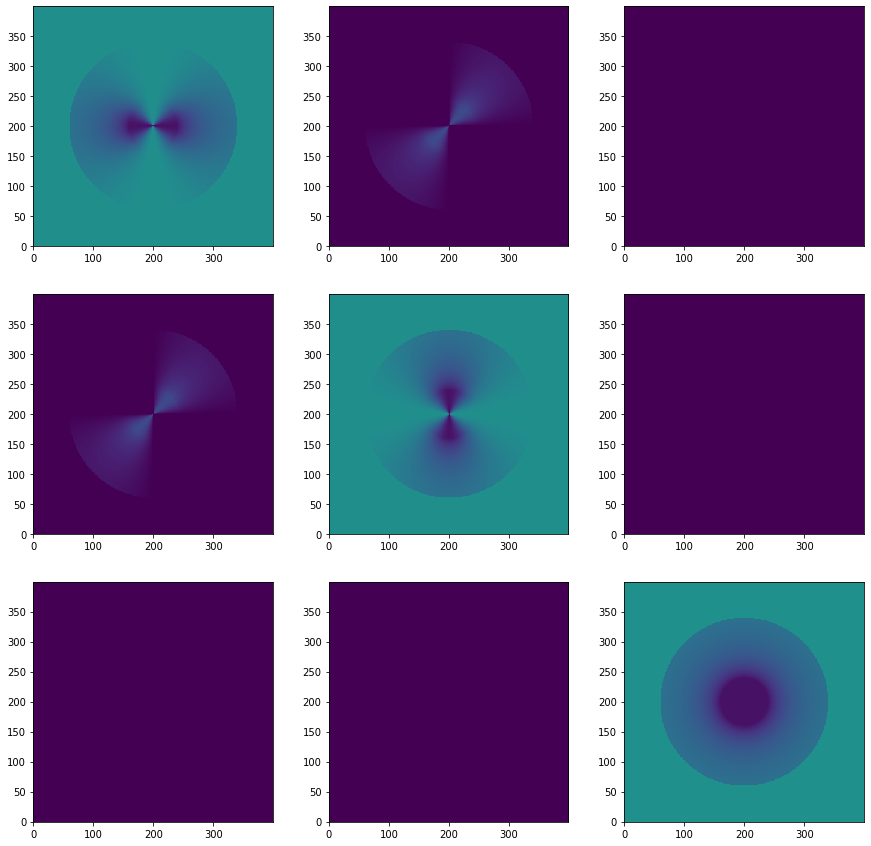

In [19]:
# Plot material to check it looks correct
plt.rcParams["figure.figsize"] = 15,15
fig, ax = plt.subplots(3,3)
ax[0,0].imshow(Materialxx, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[0,1].imshow(Materialxy, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[0,2].imshow(Materialxz, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[1,0].imshow(Materialyx, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[1,1].imshow(Materialyy, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[1,2].imshow(Materialyz, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[2,0].imshow(Materialzx, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[2,1].imshow(Materialzy, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
ax[2,2].imshow(Materialzz, interpolation='none', vmin = 0, vmax = 2, aspect=1, origin='lower')
plt.show()

In [21]:
Material = np.concatenate((Materialxx,Materialxy,Materialyx,Materialyy,Materialzz)) # Combine each component into 1 array
df = pd.DataFrame(Material)   # convert to pandas dataframe
df.to_csv('SchwarzschildBH2_400_40.csv')  # Export as csv